In [5]:
import argparse
import json
import logging
import os
import random
import time

import torch
import numpy as np

In [6]:
import sys
sys.path.append('..')
import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh
import utils.dataset as d
import models.networks as arch

In [7]:
DATA_SOURCE = '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/'
EXPERIMENTS_DIR = '../experiments/epochs_2000_weight_0.5/'
CHECKPOINT = 'latest'
split_filename = '../split_train.json'
specs_filename = os.path.join(EXPERIMENTS_DIR, "specs.json")

LATENT_CODE_DIR = ws.latent_codes_subdir

In [8]:
specs = json.load(open(specs_filename))
latent_size = specs["CodeLength"]
gripper_weight = specs["GripperWeight"]

In [9]:
decoder = arch.dsdfDecoder(latent_size, **specs["NetworkSpecs"])

decoder = torch.nn.DataParallel(decoder)

saved_model_state = torch.load(
    os.path.join(
        EXPERIMENTS_DIR, ws.model_params_subdir, CHECKPOINT + ".pth")
)

saved_model_epoch = saved_model_state["epoch"]

decoder.load_state_dict(saved_model_state["model_state_dict"])

decoder = decoder.module.cuda()

In [10]:
with open(split_filename, "r") as f:
    split = json.load(f)

# npz_filenames = utils.data_utils.dsdf_get_instance_filenames(
#     args.data_source, split)
npz_filenames = utils.data_utils.get_instance_filelist(DATA_SOURCE, split)

# random.shuffle(npz_filenames) # WHY??? DISABLE THIS FOR CHECKING REPRODUCIBILITY

In [7]:
for f in npz_filenames:
    print(f[-15:])

_graspnum_0.npz
_graspnum_1.npz
_graspnum_2.npz
_graspnum_3.npz
_graspnum_4.npz
_graspnum_5.npz
_graspnum_6.npz
_graspnum_7.npz
_graspnum_8.npz
_graspnum_9.npz
graspnum_10.npz
graspnum_11.npz
graspnum_12.npz
graspnum_13.npz
graspnum_14.npz
graspnum_15.npz
graspnum_16.npz
graspnum_17.npz
graspnum_18.npz
graspnum_19.npz
graspnum_20.npz
graspnum_21.npz
graspnum_22.npz
graspnum_23.npz
graspnum_24.npz
graspnum_25.npz
graspnum_26.npz
graspnum_27.npz
graspnum_28.npz
graspnum_29.npz
graspnum_30.npz
graspnum_31.npz
graspnum_32.npz
graspnum_33.npz
graspnum_34.npz
graspnum_35.npz
graspnum_36.npz
graspnum_37.npz
graspnum_38.npz
graspnum_39.npz


In [11]:
latent_vecs = ws.load_latent_vectors(EXPERIMENTS_DIR, CHECKPOINT)
print(latent_vecs.shape)

torch.Size([40, 256])


In [13]:
# index_to_select_1 = random.randint(0, len(npz_filenames)-1)
# index_to_select_2 = random.randint(0, len(npz_filenames)-1)

index_to_select_1 = 31
index_to_select_2 = 36

print(index_to_select_1, index_to_select_2)

npz_1 = npz_filenames[index_to_select_1]
npz_2 = npz_filenames[index_to_select_2]

full_filename = npz_1

print(index_to_select_1, npz_1[-15:])
print(index_to_select_2, npz_2[-15:])


31 36
31 graspnum_31.npz
36 graspnum_36.npz


In [14]:
latent_vec_1 = latent_vecs[index_to_select_1]
latent_vec_2 = latent_vecs[index_to_select_2]

In [15]:
latent_vec_1 = latent_vec_1.squeeze()
latent_vec_2 = latent_vec_2.squeeze()

In [45]:
# ####### MESH RECONSTRUCTION CODE!

# is_gripper = True

# if is_gripper:
#     mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_{npz[-15:]}')
# else:
#     mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_o_{npz[-15:]}')


# latent_vec = latent_vec.squeeze().cuda()
# with torch.no_grad():
#     utils.mesh.create_mesh_custom(
#         decoder, latent_vec, mesh_filename, N=256, max_batch=int(2 ** 18), isGripper=is_gripper)


In [16]:
# IMPORTANT: HAVE SHUFFLE = FALSE SO THAT SAME DATA POINT IS LOADED AS index_to_select

sdf_dataset = d.SDFSamples(DATA_SOURCE, split, 1000000)

sdf_loader = torch.utils.data.DataLoader(
    sdf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    drop_last=True )

In [17]:
samples_1, idx_1, npzfile_1 = sdf_dataset[index_to_select_1]
samples_2, idx_2, npzfile_2 = sdf_dataset[index_to_select_2]
print(npzfile_1[-40:], npzfile_2[-40:])

# queries = samples[:, :3] # Need to pass this through the network
# gt_sdf_obj = samples[:, 3].squeeze().numpy()
# gt_sdf_grp = samples[:, 4].squeeze().numpy()
# print(gt_sdf_grp.shape)

00/sdf/fetch_gripper/sdf_graspnum_31.npz 00/sdf/fetch_gripper/sdf_graspnum_36.npz


In [50]:
# print(samples.shape)

In [18]:
def get_cvx_combination(l1, l2, alpha):
    return l1 * alpha + (1 - alpha) * l2

In [19]:
alpha_list = np.linspace(0, 1, 11)

In [16]:
# with torch.no_grad():
#     queries, sdf_obj, sdf_grp = utils.eval_utils.eval_query_pc(decoder, latent_vec.cuda(), queries)

In [55]:
# idx = 4
# cvx_code = get_cvx_combination(latent_vec_1, latent_vec_2, alpha_list[idx])
# cvx_code = cvx_code.cuda()

In [62]:
# queries, sdf_obj, sdf_grp = utils.eval_utils.eval_random_query_pc(decoder, cvx_code, num_samples=1000000)

In [20]:
latent_codes = [get_cvx_combination(latent_vec_1, latent_vec_2, alpha_list[i]) for i in range(len(alpha_list))]

results = [utils.eval_utils.eval_random_query_pc(decoder, latent_codes[i].cuda(), num_samples=100000) for i in range(len(alpha_list))]



In [82]:
idx = 7

queries, sdf_obj, sdf_grp = results[idx]
queries = queries.detach().cpu().numpy()
sdf_obj = sdf_obj.detach().cpu().numpy()
sdf_grp = sdf_grp.detach().cpu().numpy()

In [79]:
print(sdf_grp.shape)
print(sdf_obj.shape)
print(queries.shape)

(100000,)
(100000,)
(100000, 3)


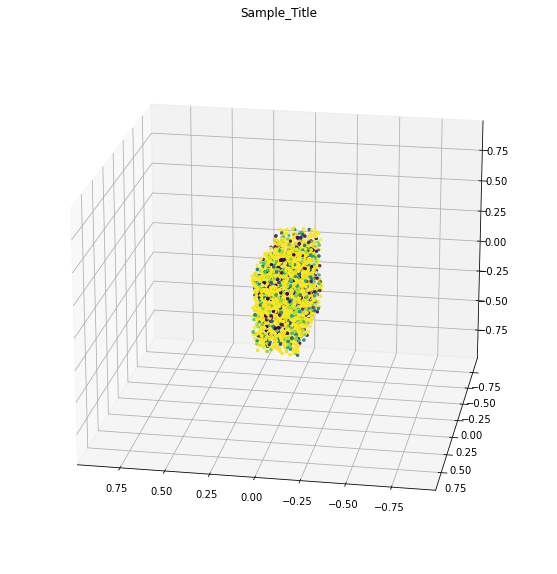

In [62]:
plot_sdf(queries[sdf_obj < 1e-4], sdf_obj)

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_sdf_2(xyz, sdf, xyz2, sdf2, title='Sample_Title', n_display=10000, fname=None):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ind2 = np.random.choice(range(xyz2.shape[0]), n_display)
    data2 = xyz2[ind].T
    
    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    if fname:
        plt.savefig(fname)
    else:
        plt.show()


def plot_sdf(xyz, sdf, title='Sample_Title', n_display=10000, fname=None):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    if fname:
        plt.savefig(fname)
    else:
        plt.show()


def plot_sdf_with_box(xyz, sdf, box_pts, title='Sample_Title', n_display=10000, fname=None):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T
    
    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.scatter(box_pts[0], box_pts[2], box_pts[1], s=2, c='red')
    
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    if fname:
        plt.savefig(fname)
    else:
        plt.show()

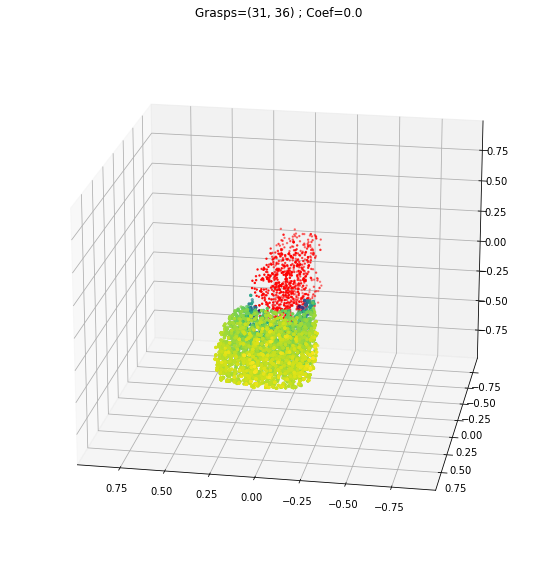

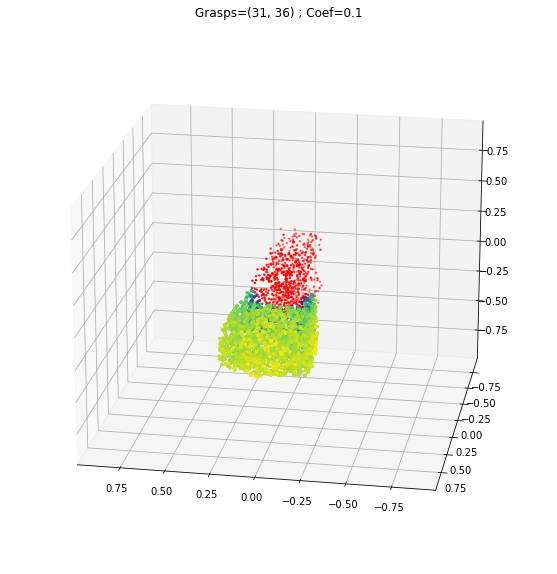

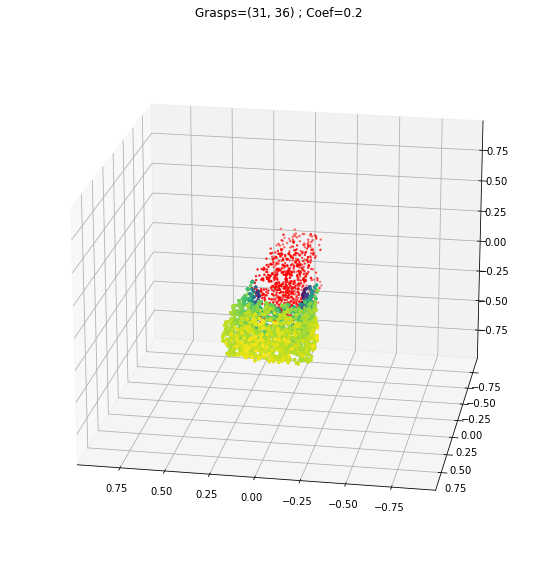

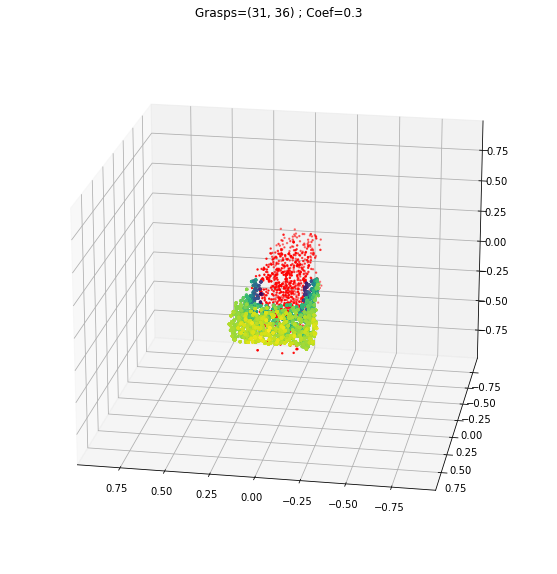

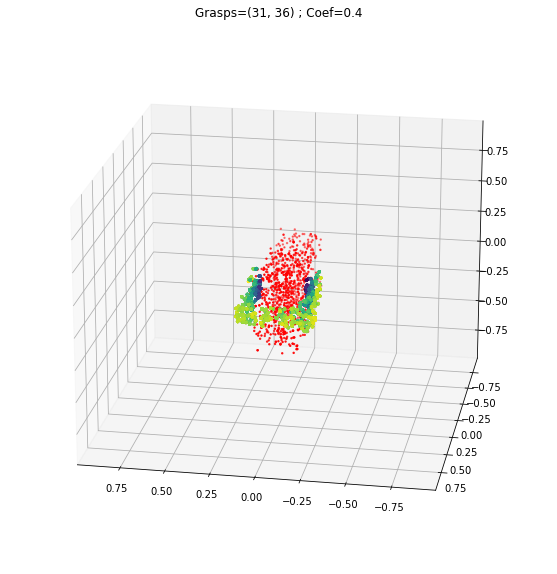

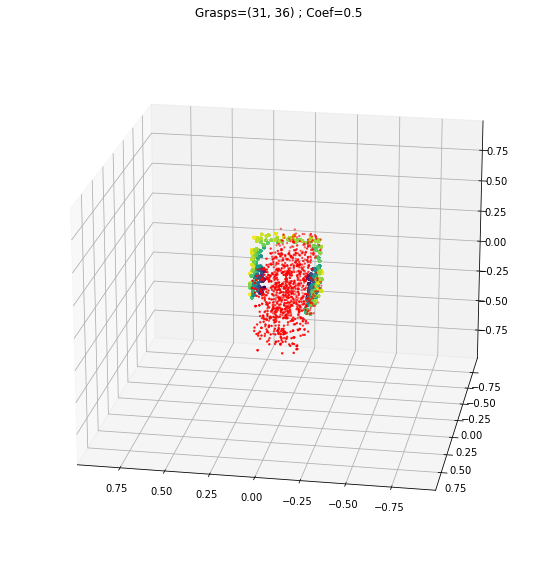

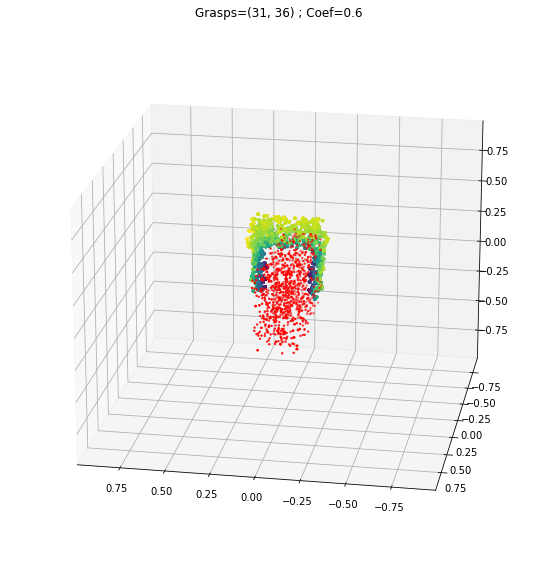

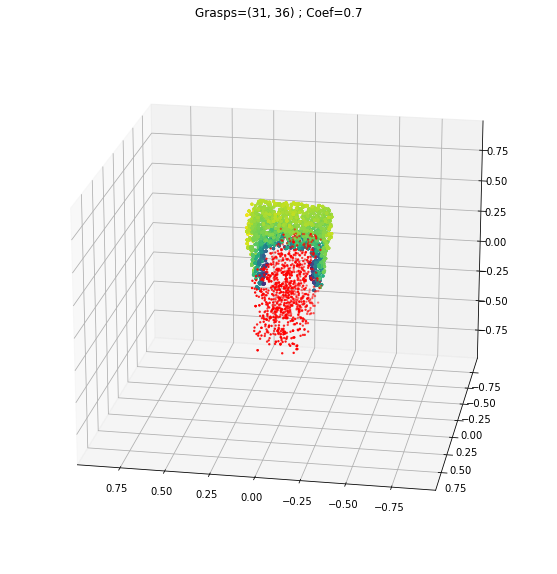

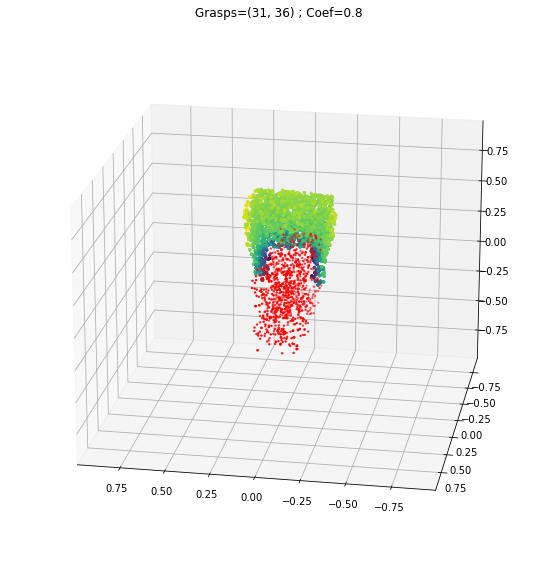

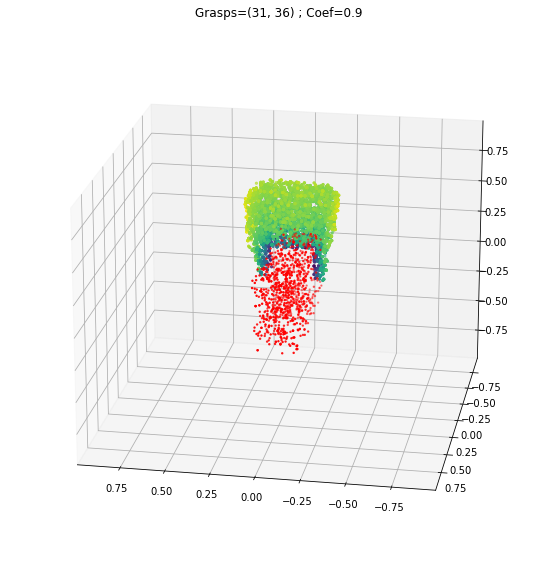

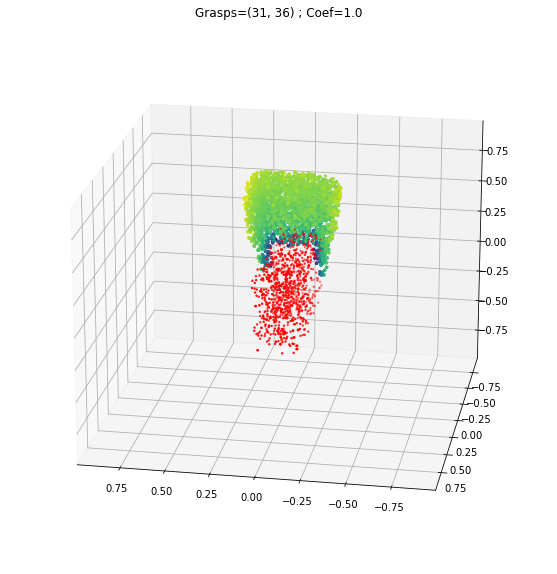

In [66]:
box_data = queries[sdf_obj < 1e-3]
indices = np.random.choice(range(box_data.shape[0]), 1000)
box_data = box_data[indices].T

for i in range(len(alpha_list)):
    queries, sdf_obj, sdf_grp = results[i]
    queries = queries.detach().cpu().numpy()
    sdf_obj = sdf_obj.detach().cpu().numpy()
    sdf_grp = sdf_grp.detach().cpu().numpy()    
    EPS = -1e-4
    ind_grp = sdf_grp <= EPS
    
    fname_save = os.path.join(EXPERIMENTS_DIR, 'viz', 
                              f'interpolation_{index_to_select_1}_{index_to_select_2}_{alpha_list[i]:.1f}.png')
    
    plot_sdf_with_box(queries[ind_grp], sdf_obj[ind_grp], box_data, 
             title=f'Grasps={index_to_select_1, index_to_select_2} ; Coef={alpha_list[i]:.1f}',
             fname=fname_save)

    
    
# EPS = -1e-4
# ind_grp = sdf_grp <= EPS
# plot_sdf(queries[ind_grp], sdf_obj[ind_grp])

In [35]:
import pyrender
# Just pass the points you want to visualize
def plt_points_3d(pts):
    colors = np.zeros(pts.shape)
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

# Pass the point as well as the sdf to see inside/outside points
def plt_points_sdf(pts, sdf, eps=1e-4):
    colors = np.zeros(pts.shape)
    colors[sdf < eps, 1] = 1
    colors[sdf > eps, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

def plt_points_sdf_compare(pts, sdf_gt, sdf_pred):
    colors = np.zeros(pts.shape)
    colors[sdf_gt < 0, 1] = 1
    colors[sdf_gt > 0, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)
    
    colors2 = np.zeros(pts.shape)
    colors2[sdf_pred < 0, 1] = 1
    colors2[sdf_pred > 0, 0] = 1
    cloud2 = pyrender.Mesh.from_points(pts, colors=colors2)
    scene2 = pyrender.Scene()
    scene2.add(cloud2)
    viewer = pyrender.Viewer(scene2, use_raymond_lighting=True, point_size=2)

In [67]:
plt_points_3d(queries[sdf_grp < 1e-4])

In [68]:
plt_points_3d(queries[sdf_obj < 1e-4])

In [69]:
plt_points_sdf(queries, sdf_grp)

In [32]:
plt_points_sdf(queries, sdf_obj)